This notebook is part of the supplementary material of the books "Online Machine Learning - Eine praxisorientiere Einführung",  
https://link.springer.com/book/9783658425043 and "Online Machine Learning - A Practical Guide with Examples in Python" https://link.springer.com/book/9789819970063
The contents are open source and published under the "BSD 3-Clause License".
This software is provided "as is" without warranty of any kind, either express or implied, including but not limited to implied warranties of merchantability and fitness for a particular purpose. The author or authors assume no liability for any damages or liability, whether in contract, tort, or otherwise, arising out of or in connection with the software or the use or other dealings with the software.

# Chapter 9: Bike Sharing

In [1]:
import warnings
import copy
import numpy as np
import pandas as pd
from sklearn import preprocessing as preprocessing_sklearn
from sklearn import tree as sklearn_tree
from sklearn.pipeline import Pipeline
from spotriver.evaluation.eval_bml import eval_bml_horizon, eval_bml_landmark, eval_bml_window, eval_oml_horizon, plot_bml_oml_horizon_predictions, plot_bml_oml_horizon_metrics
warnings.filterwarnings("ignore")
from river import preprocessing as preprocessing_river
from river import tree as river_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
import numpy as np
experiment_name = "ch09_bike"
import os
if not os.path.exists('./figures'):
    os.makedirs('./figures')

## Time-related feature engineering: 

* https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html presents an example that introduces different strategies to leverage time-related features for a bike sharing demand regression task that is highly dependent on business cycles (days, weeks, months) and yearly season cycles.

## The Bike Sharing Demand Dataset

* To perform a data exploration on the Bike Sharing Demand dataset, the data is loaded from the OpenML repository.

In [2]:
from sklearn.datasets import fetch_openml
bike_sharing = fetch_openml(
    "Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas"
)
df = bike_sharing.frame

In [3]:
df.shape

(17379, 13)

In [4]:
print(df[1:5].to_markdown(floatfmt=".2f"))

|    | season   |   year |   month |   hour | holiday   |   weekday | workingday   | weather   |   temp |   feel_temp |   humidity |   windspeed |   count |
|---:|:---------|-------:|--------:|-------:|:----------|----------:|:-------------|:----------|-------:|------------:|-----------:|------------:|--------:|
|  1 | spring   |      0 |       1 |      1 | False     |         6 | False        | clear     |   9.02 |       13.63 |       0.80 |        0.00 |      40 |
|  2 | spring   |      0 |       1 |      2 | False     |         6 | False        | clear     |   9.02 |       13.63 |       0.80 |        0.00 |      32 |
|  3 | spring   |      0 |       1 |      3 | False     |         6 | False        | clear     |   9.84 |       14.39 |       0.75 |        0.00 |      13 |
|  4 | spring   |      0 |       1 |      4 | False     |         6 | False        | clear     |   9.84 |       14.39 |       0.75 |        0.00 |       1 |


* To get a quick understanding of the periodic patterns of the data, let's look at the average demand per hour during a week.
* Note that the week starts on a Sunday, which is a weekend.
* We can clearly distinguish between commuter traffic in the morning and evening of work days and recreational bicycle use on weekends, with peak demand in the middle of the days:

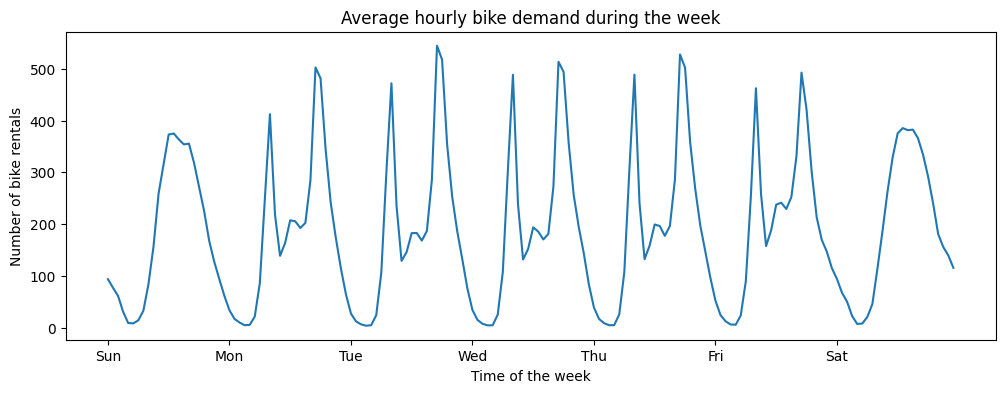

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)
plt.savefig("./figures/ch09_bike_demand_en.pdf")

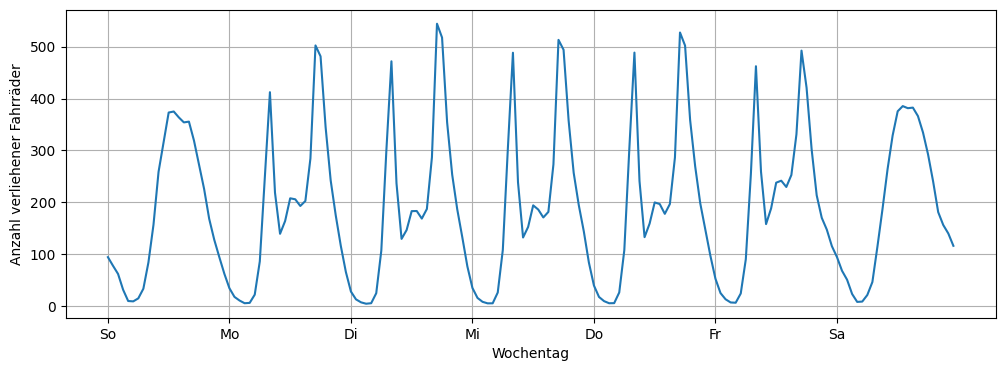

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["So", "Mo", "Di", "Mi", "Do", "Fr", "Sa"],
    xlabel="Wochentag",
    ylabel="Anzahl verliehener Fahrräder",
)
ax.grid(True)
plt.savefig("./figures/ch09_bike_demand_de.pdf")

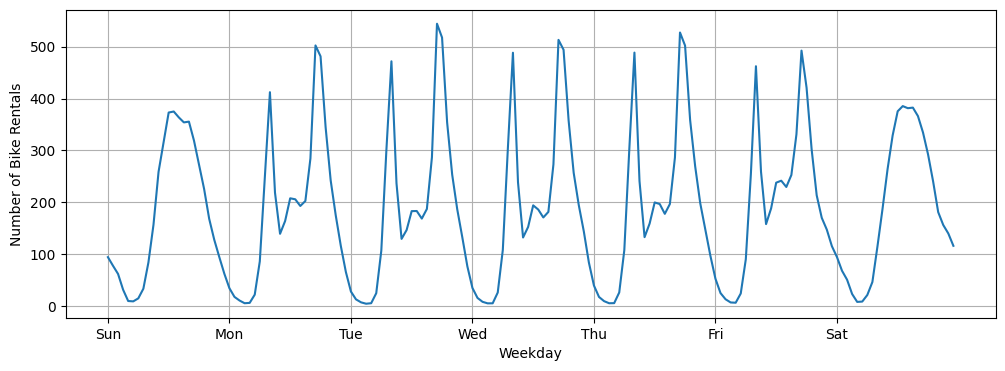

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Weekday",
    ylabel="Number of Bike Rentals",
)
ax.grid(True)
plt.savefig("./figures/ch09_bike_demand.pdf")

* The target of the prediction problem is the absolute count of bike rentals on a hourly basis:

In [8]:
df["count"].max()

977

* The target variable (number of hourly bicycle rentals) is rescaled to predict relative demand so that the mean absolute error can be more easily interpreted as a fraction of the maximum demand.

In [9]:
df["count"] = df["count"] / df["count"].max()

* Note:  
    * The fitting method of the models used in this notebook minimizes the mean squared error to estimate the conditional mean, rather than the mean absolute error that would fit an estimator of the conditional median.
    * When we report power measurement on the test set in the discussion, we focus instead on the mean absolute error, which is more intuitive than the root mean square error. 
* Note, however, that in this study the best models for one metric are also the best for the other.

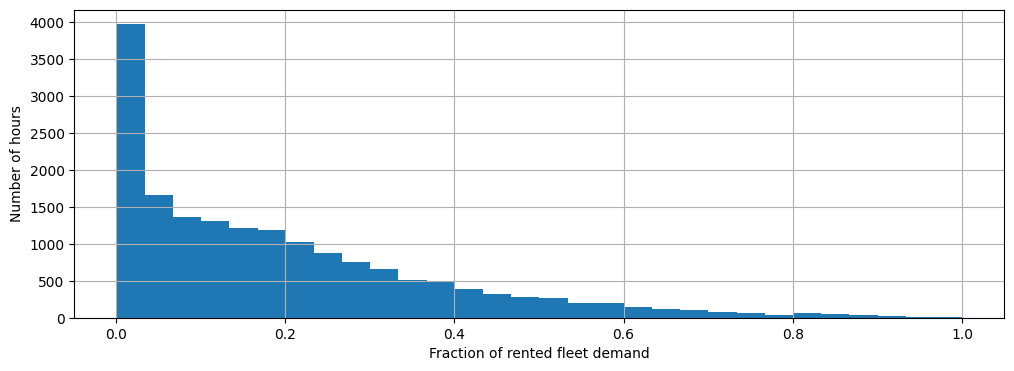

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
df["count"].hist(bins=30, ax=ax)
_ = ax.set(
    xlabel="Fraction of rented fleet demand",
    ylabel="Number of hours",
)

* The input data frame is a timed hourly log of variables describing weather conditions. It contains both numeric and categorical variables.
* Note that the time information has already been expanded into several supplemental columns.

In [11]:
df.drop("count", axis="columns")

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0000
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0000
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0000
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0000
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,spring,1,12,19,False,1,True,misty,10.66,12.880,0.60,11.0014
17375,spring,1,12,20,False,1,True,misty,10.66,12.880,0.60,11.0014
17376,spring,1,12,21,False,1,True,clear,10.66,12.880,0.60,11.0014
17377,spring,1,12,22,False,1,True,clear,10.66,13.635,0.56,8.9981


* We now introspect the distribution of the categorical variables, starting with "weather":

In [12]:
df["weather"].value_counts()

weather
clear         11413
misty          4544
rain           1419
heavy_rain        3
Name: count, dtype: int64

* Since there are only 3 "heavy_rain" events, we cannot use this category to train machine learning models with cross validation.
* Instead, we simplify the representation by collapsing those into the "rain" category.

In [13]:
df["weather"].replace(to_replace="heavy_rain", value="rain", inplace=True)
df["weather"].value_counts()

weather
clear    11413
misty     4544
rain      1422
Name: count, dtype: int64

As expected, the "season" variable is well balanced:

In [14]:
df["season"].value_counts()

season
fall      4496
summer    4409
spring    4242
winter    4232
Name: count, dtype: int64

## Correlation Plot

In [15]:
from spotriver.plot.stats import corrplot
corrplot(df)

,year,month,hour,weekday,temp,feel_temp,humidity,windspeed,count
year,nan,nan,nan,nan,nan,nan,nan,nan,nan
month,-0.010473,nan,nan,nan,nan,nan,nan,nan,nan
hour,-0.003867,-0.005772,nan,nan,nan,nan,nan,nan,nan
weekday,-0.004485,0.010400,-0.003498,nan,nan,nan,nan,nan,nan
temp,0.040913,0.201691,0.137603,-0.001795,nan,nan,nan,nan,nan
feel_temp,0.039222,0.208096,0.133750,-0.008821,0.987672,nan,nan,nan,nan
humidity,-0.083546,0.164411,-0.276498,-0.037158,-0.069881,-0.051918,nan,nan,nan
windspeed,-0.008740,-0.135386,0.137252,0.011502,-0.023125,-0.062336,-0.290105,nan,nan
count,0.250495,0.120638,0.394071,0.026900,0.404772,0.400929,-0.322911,0.093234,nan


## Full, Train, and Test Data

In [16]:
# all_splits = list(ts_cv.split(X, y))
# train_0, test_0 = all_splits[0]

We split the data into 60% for training and 40% for testing.

In [17]:
n = df.shape[0]
k = int(n * 0.6)
train = df[0:k]
test = df[k:n]

## The Function `get_bike_sharing_data`

The function `get_bike_sharing_data` from the `spotriver` package is used to load the data from the OpenML repository. It implements the preprocessing steps described above.

In [18]:
from spotriver.data.bike_sharing import get_bike_sharing_data
df, train, test = get_bike_sharing_data()
target_column="count"

In [19]:
train.shape, test.shape

((10427, 13), (6952, 13))

##  BML Linear regression

* As usual for linear models, categorical variables need to be one-hot encoded.
* For consistency, we scale the numerical features to the same 0-1 range using class:sklearn.preprocessing.MinMaxScaler, although in this case it does not impact the results much because they are already on comparable scales:

In [20]:
categorical_columns = [
    "weather",
    "season",
    "holiday",
    "workingday",
]
categories = [
    ["clear", "misty", "rain"],
    ["spring", "summer", "fall", "winter"],
    ["False", "True"],
    ["False", "True"],
]

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
alphas = np.logspace(-6, 6, 25)
linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)

## Horizon set to one Week

In [21]:
horizon = 7*24

In [22]:
from sklearn.metrics import mean_absolute_error
metric = mean_absolute_error
df_eval_bml_horizon_linear, df_true_bml_horizon_linear = eval_bml_horizon(model = linear_pipeline,
                            train = train,
                            test = test,
                            target_column=target_column,
                            horizon=horizon, include_remainder=False, metric=metric)
df_eval_bml_landmark_linear, df_true_bml_landmark_linear = eval_bml_landmark(model = linear_pipeline,
                            train = train,
                            test = test,
                            target_column=target_column,
                            horizon=horizon, metric=metric)
df_eval_bml_window_linear, df_true_bml_window_linear = eval_bml_window(model = linear_pipeline,
                            train = train,
                            test = test,
                            target_column=target_column,
                            horizon=horizon, metric=metric)

* Note: The following figures are used in the book (fig-ch09_bike-overall-bml-lm-metrics and fig-ch09_bike-overall-bml-lm-predictions).

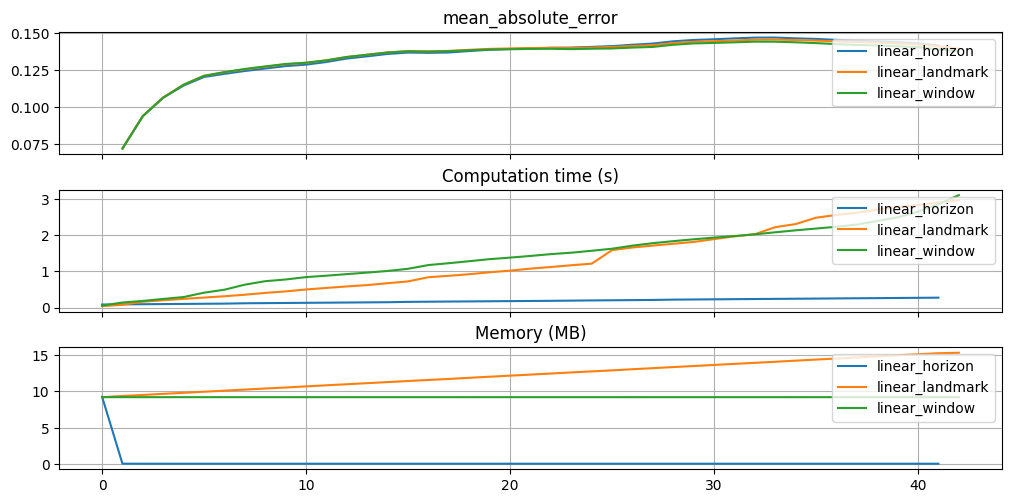

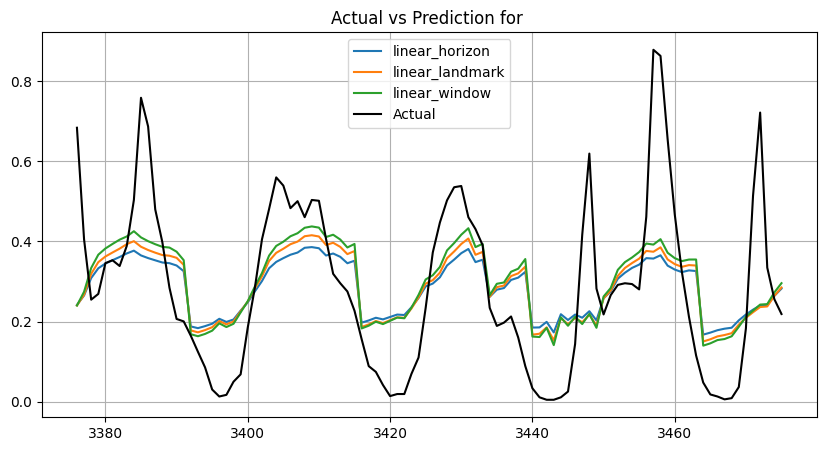

In [23]:
m = test.shape[0]
a = int(m/2)-100
b = int(m/2)
df_labels=["linear_horizon", "linear_landmark", "linear_window"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_bml_horizon_linear, df_eval_bml_landmark_linear, df_eval_bml_window_linear], df_labels=df_labels, cumulative=True, log_y=False, figsize=(10,5), metric=metric, filename="./figures/" + experiment_name+"_overall_bml_lm_metrics.pdf")
plot_bml_oml_horizon_predictions(df_true = [df_true_bml_horizon_linear[a:b], df_true_bml_landmark_linear[a:b], df_true_bml_window_linear[a:b]], target_column=target_column,  df_labels=df_labels, filename="./figures/" + experiment_name+"_overall_bml_lm_predictions.pdf")

## River OML: Linear Model

In [24]:
from river import compose
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import optim
from river import feature_extraction
from river import stats

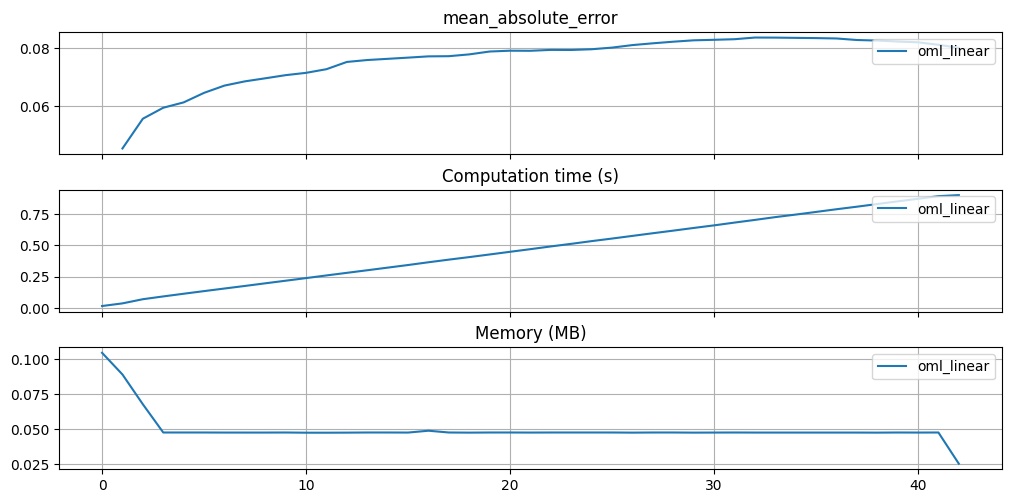

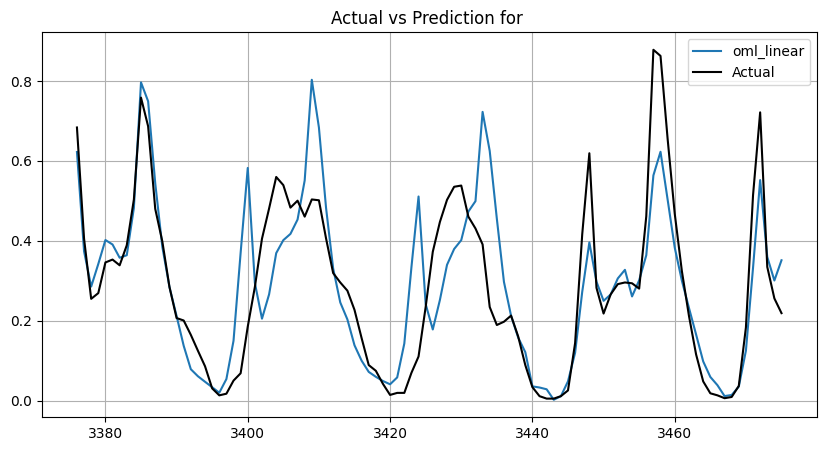

In [25]:
oml_linear_model = compose.Select('humidity', 'temp', 'feel_temp', 'windspeed')
oml_linear_model += (
    feature_extraction.TargetAgg(by=['hour'], how=stats.Mean())
)
oml_linear_model |= preprocessing.StandardScaler()
oml_linear_model |= linear_model.LinearRegression()
df_eval_oml_linear, df_true_oml_linear = eval_oml_horizon(model = oml_linear_model,
                            train = train,
                            test = test,
                            target_column=target_column,
                            horizon=horizon, metric=metric)
df_labels=["oml_linear"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_oml_linear], log_y=False, df_labels=df_labels, metric=metric,filename=None)
plot_bml_oml_horizon_predictions(df_true = [df_true_oml_linear[a:b]], target_column=target_column,  df_labels=df_labels)


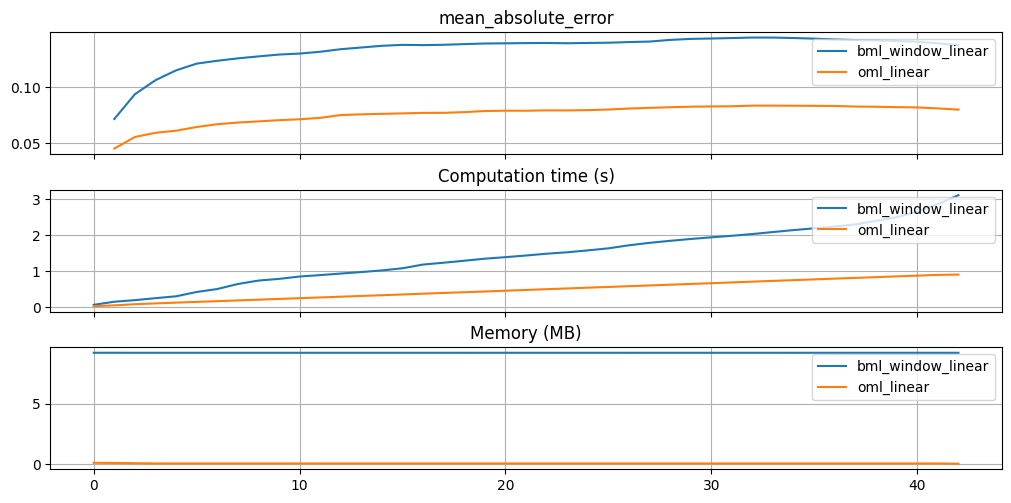

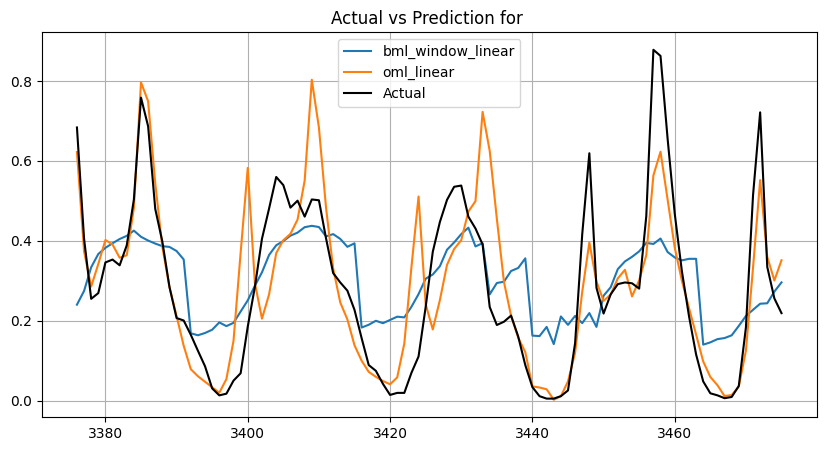

In [26]:

df_labels=["bml_window_linear", "oml_linear"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_bml_window_linear, df_eval_oml_linear], log_y=False, df_labels=df_labels, metric=metric)
plot_bml_oml_horizon_predictions(df_true = [df_true_bml_window_linear[a:b], df_true_oml_linear[a:b]], target_column=target_column,  df_labels=df_labels, log_y=False)

## Overall Comparison of the BML and OML Linear Models

* Note: The following figures are used in the book (fig-ch09_bike-overall-bml_oml_lm-metrics and fig-ch09_bike-overall-bml_oml_lm-predictions)

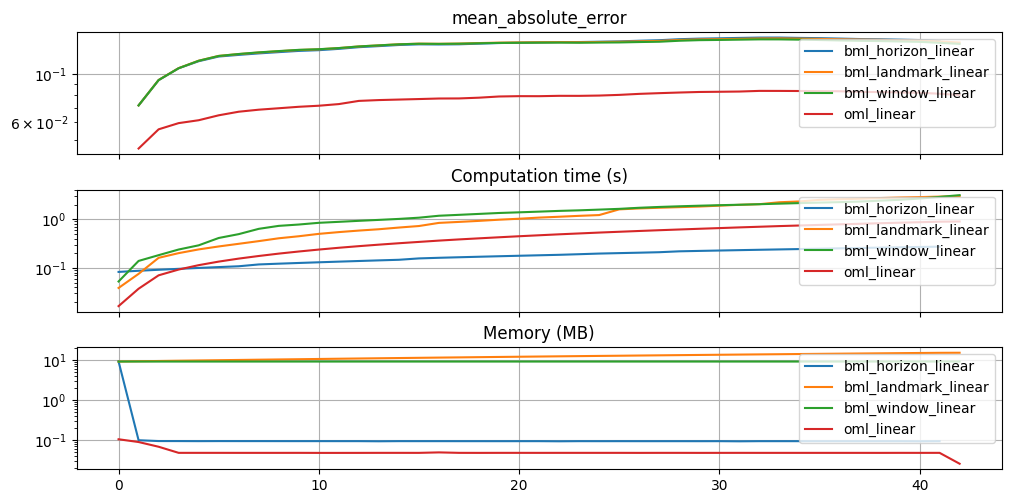

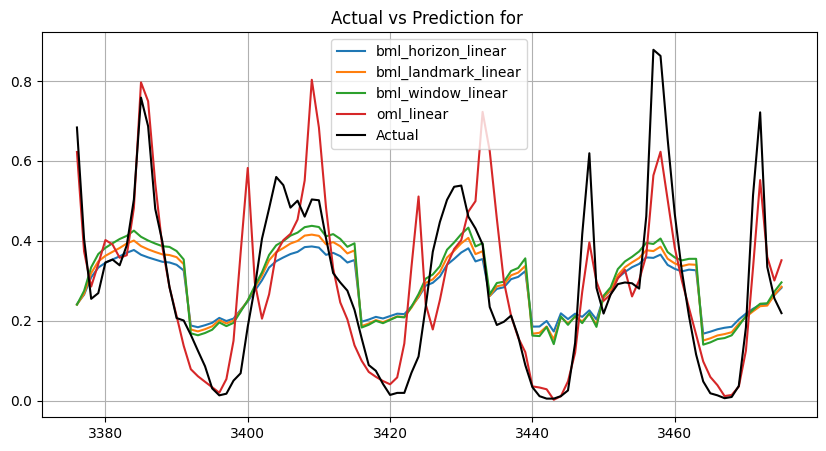

In [27]:
df_labels=["bml_horizon_linear", "bml_landmark_linear", "bml_window_linear", "oml_linear"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_bml_horizon_linear, df_eval_bml_landmark_linear, df_eval_bml_window_linear, df_eval_oml_linear], df_labels=df_labels, cumulative=True, log_y=True, figsize=(10,5), metric=metric, filename="./figures/" + experiment_name+"_overall_bml_oml_lm_metrics.pdf")
plot_bml_oml_horizon_predictions(df_true = [df_true_bml_horizon_linear[a:b], df_true_bml_landmark_linear[a:b], df_true_bml_window_linear[a:b], df_true_oml_linear[a:b]], target_column=target_column,  df_labels=df_labels, filename="./figures/" + experiment_name+"_overall_bml_oml_lm_predictions.pdf")

In [28]:
oml_linear_model

Pipeline (
  TransformerUnion (
    Select (
      feel_temp
      humidity
      temp
      windspeed
    ),
    TargetAgg (
      by=['hour']
      how=Mean ()
      target_name="y"
    )
  ),
  StandardScaler (
    with_std=True
  ),
  LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

* We can also use the debug_one method to see what happens to one particular instance.
* Let's train the model on the first 1,000 observations and then call debug_one on the next one.
* To do this, we will turn the Bike object into a Python generator with iter() function.
* The Pythonic way to read the first 1,000 elements of a generator is to use itertools.islice.
* The debug_one method shows what happens to an input set of features, step by step.

In [29]:
import itertools
from river import stream, compose, feature_extraction, preprocessing, linear_model, stats
import copy
from spotriver.data.bike_sharing import get_bike_sharing_data

# oml_linear_model = compose.Select('humidity', 'temp', 'feel_temp', 'humidity', 'windspeed')
oml_linear_model = compose.Select("year", "month", "hour", "weekday", "temp", "feel_temp", "humidity", "windspeed")
oml_linear_model += (
    feature_extraction.TargetAgg(by=['hour'], how=stats.Mean())
)
oml_linear_model |= preprocessing.StandardScaler()
oml_linear_model |= linear_model.LinearRegression()

_, train, test = get_bike_sharing_data()
X = copy.deepcopy(test)
y = X.pop("count")
dataset = stream.iter_pandas(X, y)

for x, y in itertools.islice(dataset, 1000):
    y_pred = oml_linear_model.predict_one(x)
    oml_linear_model.learn_one(x, y)

x, y = next(iter(dataset))
print(oml_linear_model.debug_one(x))

0. Input
--------
feel_temp: 22.72500 (float)
holiday: False (str)
hour: 8 (int)
humidity: 0.82000 (float)
month: 4 (int)
season: summer (str)
temp: 18.86000 (float)
weather: rain (str)
weekday: 4 (int)
windspeed: 12.99800 (float)
workingday: True (str)
year: 1 (int)

1. Transformer union
--------------------
    1.0 Select
    ----------
    feel_temp: 22.72500 (float)
    hour: 8 (int)
    humidity: 0.82000 (float)
    month: 4 (int)
    temp: 18.86000 (float)
    weekday: 4 (int)
    windspeed: 12.99800 (float)
    year: 1 (int)

    1.1 TargetAgg
    -------------
    y_mean_by_hour: 0.48114 (float64)

feel_temp: 22.72500 (float)
hour: 8 (int)
humidity: 0.82000 (float)
month: 4 (int)
temp: 18.86000 (float)
weekday: 4 (int)
windspeed: 12.99800 (float)
y_mean_by_hour: 0.48114 (float64)
year: 1 (int)

2. StandardScaler
-----------------
feel_temp: -0.11330 (float)
hour: -0.50758 (float)
humidity: 1.08461 (float)
month: 0.80633 (float)
temp: -0.16870 (float)
weekday: 0.50063 (float)
wi

## Generic OML Linear Model

In [30]:
import numbers
from river import compose
from river import linear_model
from river import preprocessing

num = compose.SelectType(numbers.Number) | preprocessing.StandardScaler()
cat = compose.SelectType(str) | preprocessing.OneHotEncoder()

oml_linear_generic = compose.Pipeline((num + feature_extraction.TargetAgg(by=['hour'], how=stats.Mean())),
                                              linear_model.LinearRegression() )


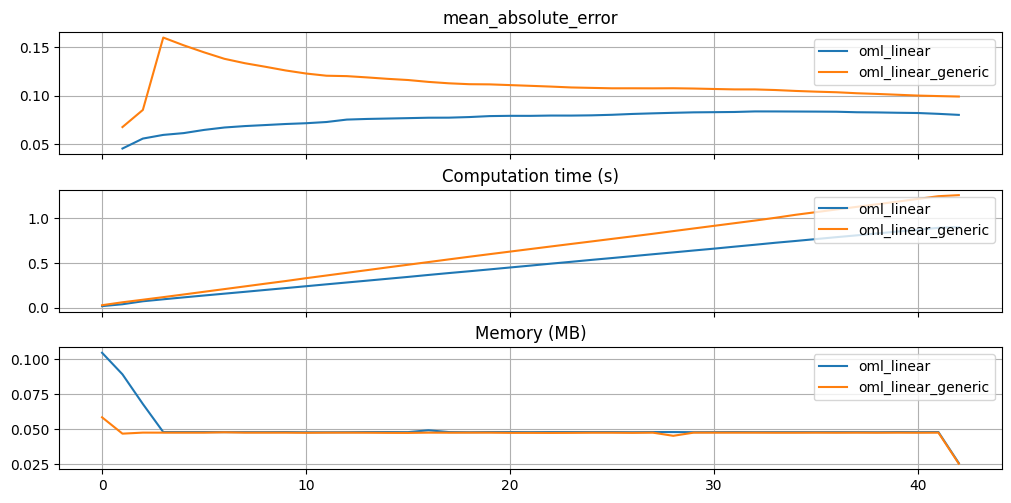

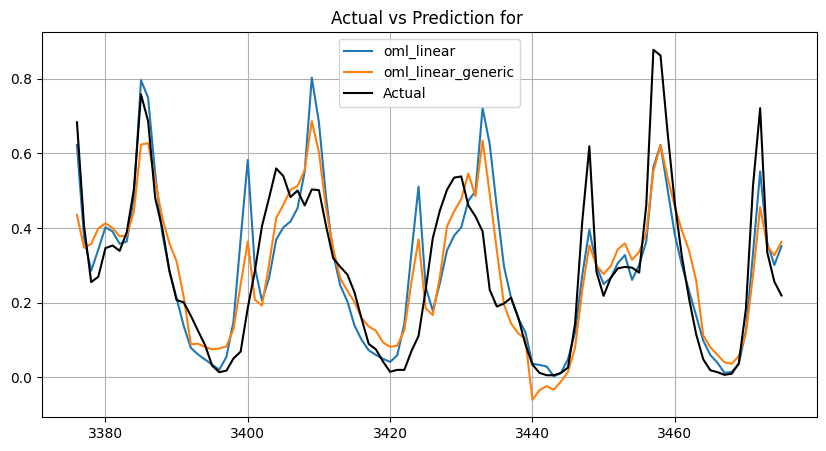

In [31]:
df_eval_oml_linear_generic, df_true_oml_linear_generic = eval_oml_horizon(model = oml_linear_generic,
                            train = train,
                            test = test,
                            target_column=target_column,
                            horizon=horizon, metric=metric)
df_labels=["oml_linear", "oml_linear_generic"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_oml_linear, df_eval_oml_linear_generic], log_y=False, df_labels=df_labels, metric=metric)
plot_bml_oml_horizon_predictions(df_true = [df_true_oml_linear[a:b], df_true_oml_linear_generic[a:b]], target_column=target_column,  df_labels=df_labels)

In [32]:
oml_linear_generic

Pipeline (
  TransformerUnion (
    Pipeline (
      Select (
        <class 'numbers.Number'>
      ),
      StandardScaler (
        with_std=True
      )
    ),
    TargetAgg (
      by=['hour']
      how=Mean ()
      target_name="y"
    )
  ),
  LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

## Gradient Boosting

* Gradient boosting regression with decision trees is often flexible enough to efficiently handle heteorogenic tabular data with a mixture of categorical and numerical features, as long as the number of samples is large enough.
* Here, we perform minimal ordinal coding for the categorical variables and then let the model know to treat them as categorical variables using a special tree splitting rule.
* Since we are using an ordinal encoder, we explicitly pass the list of categorical values to use a logical order in encoding the categories as integers instead of the lexicographic order.
* This also has the added benefit of avoiding problems with unknown categories during cross-validation.
* The numeric variables do not need to be preprocessed and for simplicity only the default hyperparameters are tried for this model:

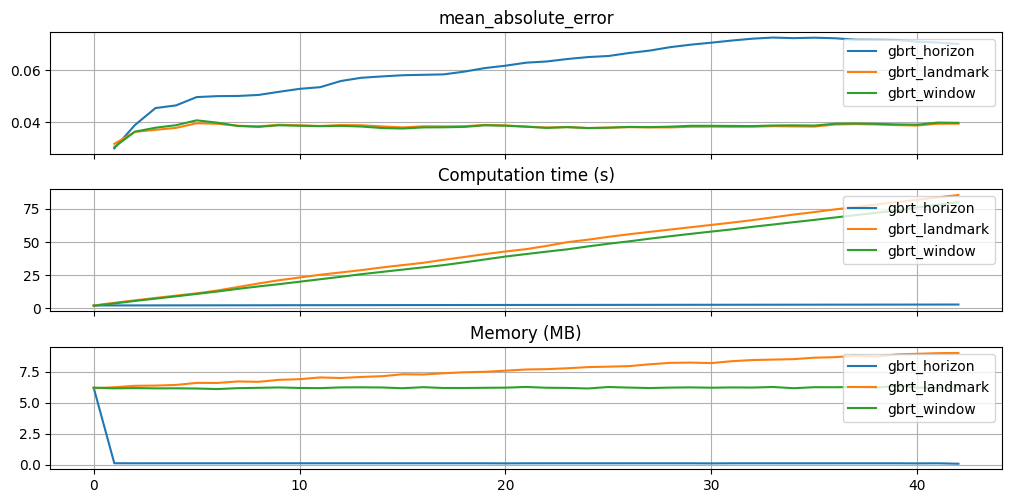

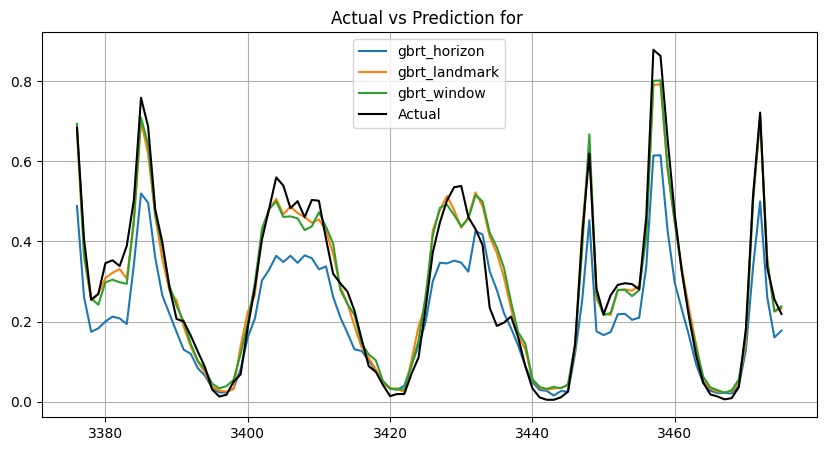

In [33]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
import numpy as np
categorical_columns = [
    "weather",
    "season",
    "holiday",
    "workingday",
]
categories = [
    ["clear", "misty", "rain"],
    ["spring", "summer", "fall", "winter"],
    ["False", "True"],
    ["False", "True"],
]
ordinal_encoder = OrdinalEncoder(categories=categories)


gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
        # Use short feature names to make it easier to specify the categorical
        # variables in the HistGradientBoostingRegressor in the next
        # step of the pipeline.
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=categorical_columns,
    ),
).set_output(transform="pandas")
horizon = 7*24
target_column = "count"
df_eval_bml_horizon_gbrt, df_true_bml_horizon_gbrt = eval_bml_horizon(model = gbrt_pipeline,
                            train = train,
                            test = test,
                            target_column=target_column,
                            horizon=horizon, metric=metric)
df_eval_bml_landmark_gbrt, df_true_bml_landmark_gbrt = eval_bml_landmark(model = gbrt_pipeline,
                            train = train,
                            test = test,
                            target_column=target_column,
                            horizon=horizon, metric=metric)
df_eval_bml_window_gbrt, df_true_bml_window_gbrt = eval_bml_window(model = gbrt_pipeline,
                            train = train,
                            test = test,
                            target_column=target_column,
                            horizon=horizon, metric=metric)
df_labels=["gbrt_horizon", "gbrt_landmark", "gbrt_window"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_bml_horizon_gbrt, df_eval_bml_landmark_gbrt, df_eval_bml_window_gbrt], df_labels=df_labels, cumulative=True, log_y=False, metric=metric)
plot_bml_oml_horizon_predictions(df_true = [df_true_bml_horizon_gbrt[a:b], df_true_bml_landmark_gbrt[a:b], df_true_bml_window_gbrt[a:b]], target_column=target_column,  df_labels=df_labels)

### Comparison: BML Gradient Boosting with OML Linear Model

* Note: These are the figures from the book (fig-ch09_bike-gbrt-olm-lm-metrics and fig-ch09_bike-gbrt-oml-lm-predictions).

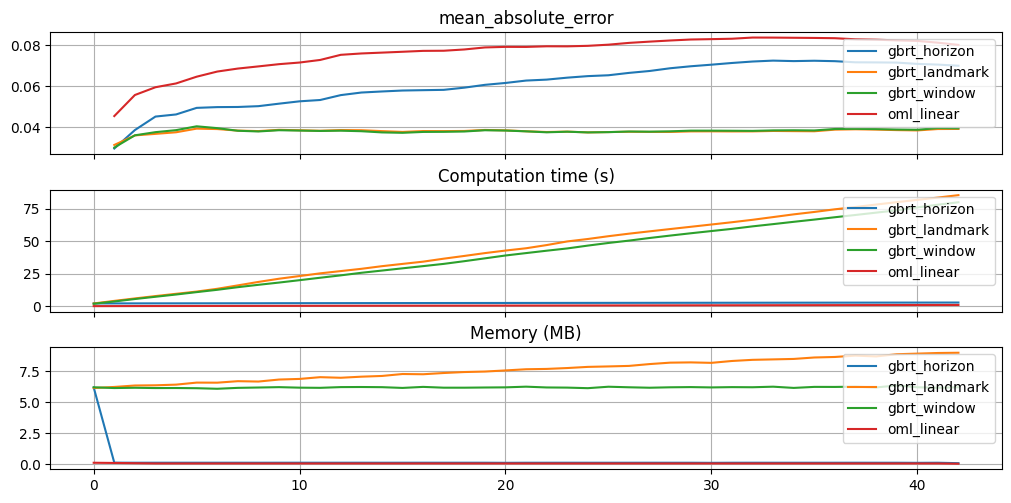

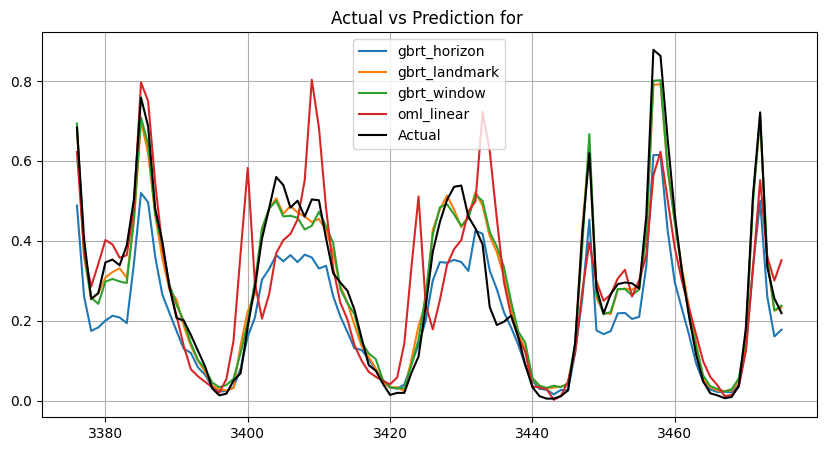

In [34]:
df_labels=["gbrt_horizon", "gbrt_landmark", "gbrt_window", "oml_linear"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_bml_horizon_gbrt, df_eval_bml_landmark_gbrt, df_eval_bml_window_gbrt, df_eval_oml_linear], df_labels=df_labels, cumulative=True, log_y=False, figsize=(10,5), metric=metric, filename="./figures/" + experiment_name+"_gbrt_oml_metrics.pdf")
plot_bml_oml_horizon_predictions(df_true = [df_true_bml_horizon_gbrt[a:b], df_true_bml_landmark_gbrt[a:b], df_true_bml_window_gbrt[a:b], df_true_oml_linear[a:b]], target_column=target_column,  df_labels=df_labels, filename="./figures/" + experiment_name+"_gbrt_oml_predictions.pdf")

# eval_oml_iter_progressive 

* This experiment describes the evaluation of the OML Iterative Progressive Learning strategy. * A "pure" OML model is used, which does not use BML wrappers.
* The prediction horizon is 1 hour, i.e., using progressive validation, each incoming example is used for prediction and then validation.
* Validation is performed using the MAE.

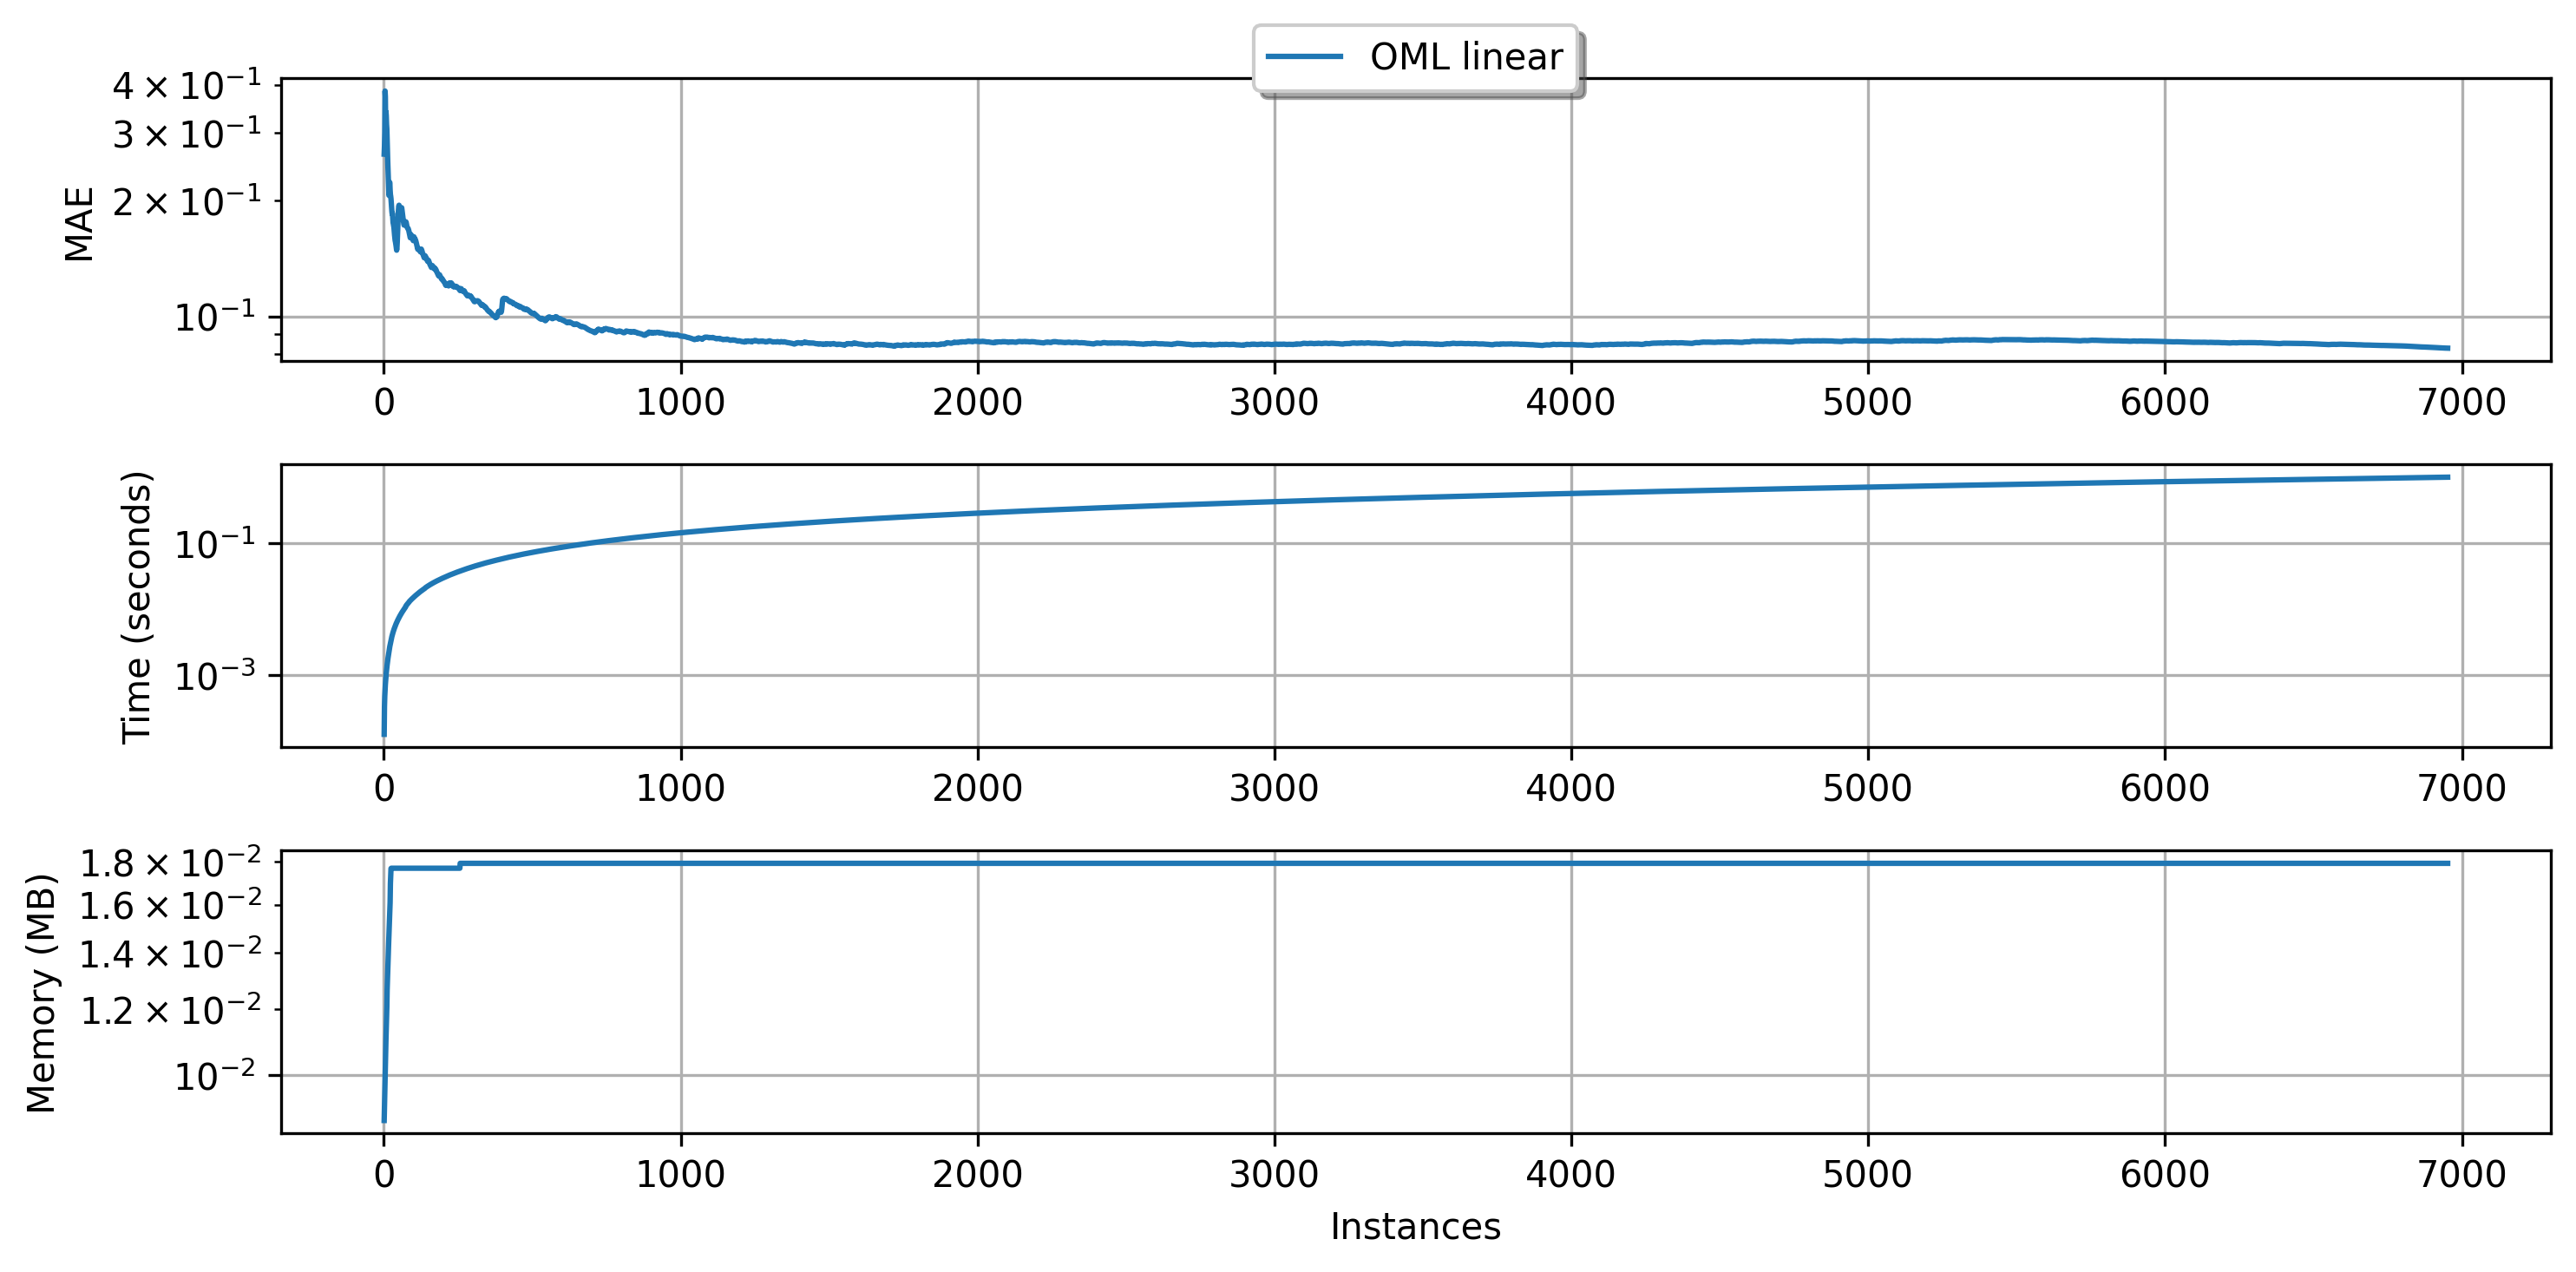

In [35]:
from spotriver.evaluation.eval_oml import eval_oml_iter_progressive, plot_oml_iter_progressive
from spotriver.data.bike_sharing import get_bike_sharing_data
from river import metrics as river_metrics
from river import stream as river_stream
from river import preprocessing as river_preprocessing

_, train, test = get_bike_sharing_data()
X_test = copy.deepcopy(test)
y_test = X_test.pop("count")
data_test = river_stream.iter_pandas(X_test, y_test)
dataset_test = list(data_test)

# oml_linear_model = compose.Select('humidity', 'temp', 'feel_temp', 'humidity', 'windspeed')
oml_linear_model = compose.Select("year", "month", "hour", "weekday", "temp", "feel_temp", "humidity", "windspeed")
oml_linear_model += (
    feature_extraction.TargetAgg(by=['hour'], how=stats.Mean())
)
oml_linear_model |= preprocessing.StandardScaler()
oml_linear_model |= linear_model.LinearRegression()

res_num = eval_oml_iter_progressive(
    dataset = list(dataset_test),
    step = 1,
    metric = river_metrics.MAE(),
    models =
    {
        "OML linear": oml_linear_model,
    }
)
plot_oml_iter_progressive(res_num, log_y=True)

In [36]:
df_eval_bml_horizon_1_gbrt, df_true_bml_horizon_1_gbrt = eval_bml_horizon(model = gbrt_pipeline,
                            train = train,
                            test = test,
                            target_column=target_column,
                            horizon=len(test), metric=metric)
df_eval_bml_horizon_1_gbrt

,Metric,Memory (MB),CompTime (s)
0,NaN,6.178200,2.060543
1,0.073374,2.414537,0.022132


In [37]:
# train = df[0:1]
# test = df[1:-1]
df_eval_4, df_true_4 = eval_oml_horizon(model = oml_linear_model,
                            train = train.tail(10),
                            test = test,
                            target_column=target_column,
                            horizon=1,
                            oml_grace_period=1,metric=metric)


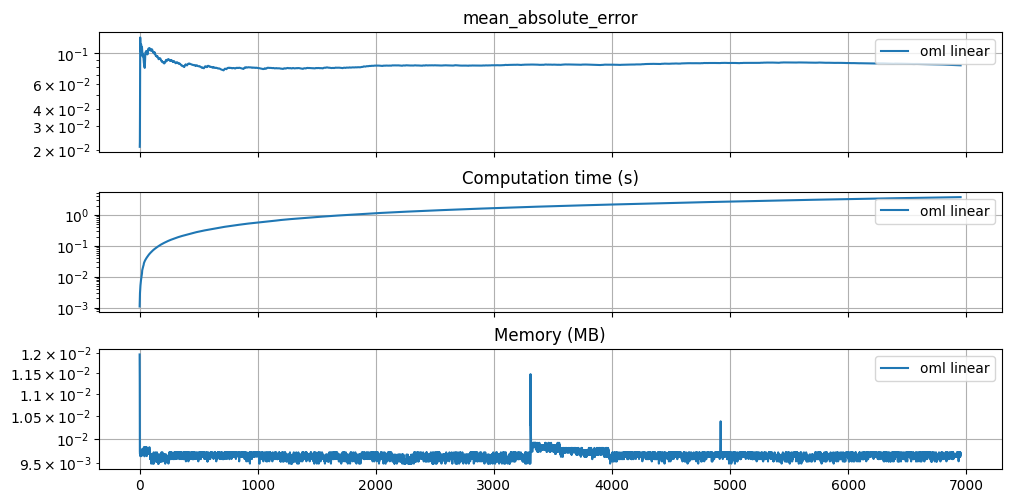

In [38]:
df_labels=["oml linear"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_4], log_y=True, df_labels=df_labels, cumulative=True, metric=metric)

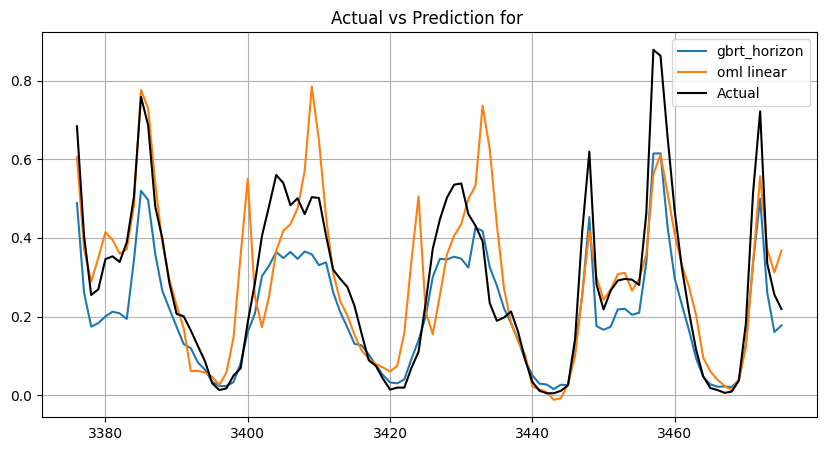

In [39]:
df_labels=["gbrt_horizon", "oml linear"]
plot_bml_oml_horizon_predictions(df_true = [df_true_bml_horizon_gbrt[a:b], df_true_4[a:b]], target_column=target_column,  df_labels=df_labels)

# OML HTR/HATR

In [40]:
from river.tree import HoeffdingTreeRegressor, HoeffdingAdaptiveTreeRegressor
from river import feature_extraction
from river import stats, compose, preprocessing, tree

#  The HTR Model

htr_model = compose.Select("weekday", "month", "temp", "feel_temp", "humidity", "windspeed")
# compose.Select('humidity', 'temp', 'feel_temp', 'windspeed')
htr_model += (
    feature_extraction.TargetAgg(by=['hour'], how=stats.Mean())
)
htr_model |= preprocessing.StandardScaler()
# htr_model |= HoeffdingTreeRegressor()
htr_model |= HoeffdingTreeRegressor(splitter=tree.splitter.QOSplitter())
df_eval_htr, df_true_htr = eval_oml_horizon(model = htr_model,
                            train = train,
                            test = test,
                            target_column=target_column,
                            horizon=horizon, metric=metric)

# The HATR Model

hatr_model = compose.Select("weekday", "month", "temp", "feel_temp", "humidity", "windspeed")
# compose.Select('humidity', 'temp', 'feel_temp', 'windspeed')
hatr_model += (
    feature_extraction.TargetAgg(by=['hour'], how=stats.Mean())
)
hatr_model |= preprocessing.StandardScaler()
hatr_model |= HoeffdingAdaptiveTreeRegressor(splitter=tree.splitter.QOSplitter())
df_eval_hatr, df_true_hatr = eval_oml_horizon(model = hatr_model,
                            train = train,
                            test = test,
                            target_column=target_column,
                            horizon=horizon, metric=metric)

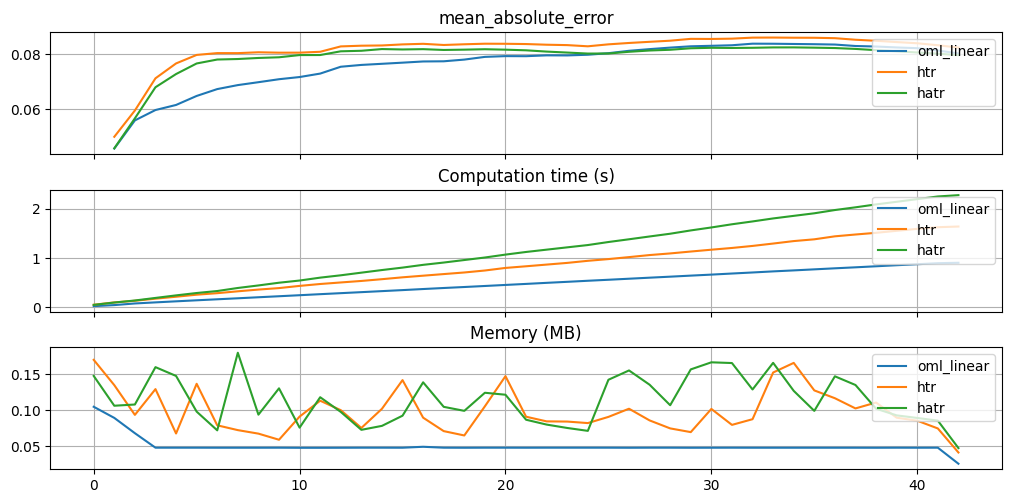

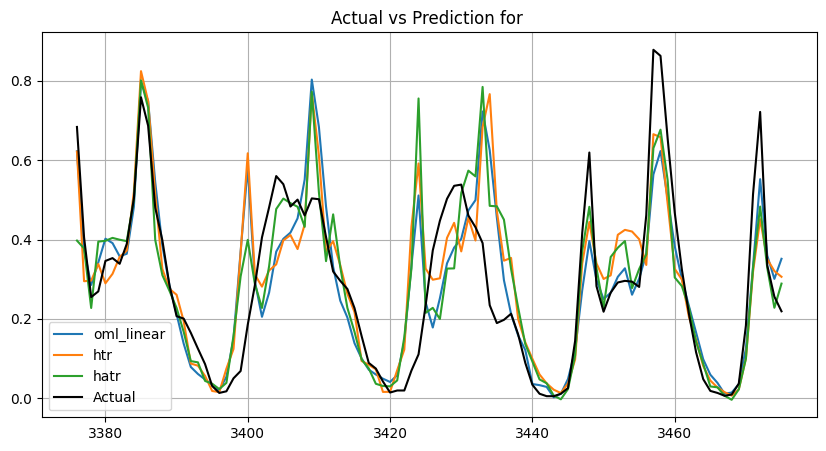

In [41]:

df_labels=["oml_linear", "htr", "hatr"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_oml_linear, df_eval_htr, df_eval_hatr], log_y=False, df_labels=df_labels, metric=metric, filename="./figures/" + experiment_name+"_oml_lm_htr_hatr_metrics.pdf")
plot_bml_oml_horizon_predictions(df_true = [df_true_oml_linear[a:b], df_true_htr[a:b], df_true_hatr[a:b]], target_column=target_column,  df_labels=df_labels, filename="./figures/" + experiment_name+"_oml_lm_htr_hatr_predictions.pdf")


## Comparison of the  OML HTR/HATR Methods

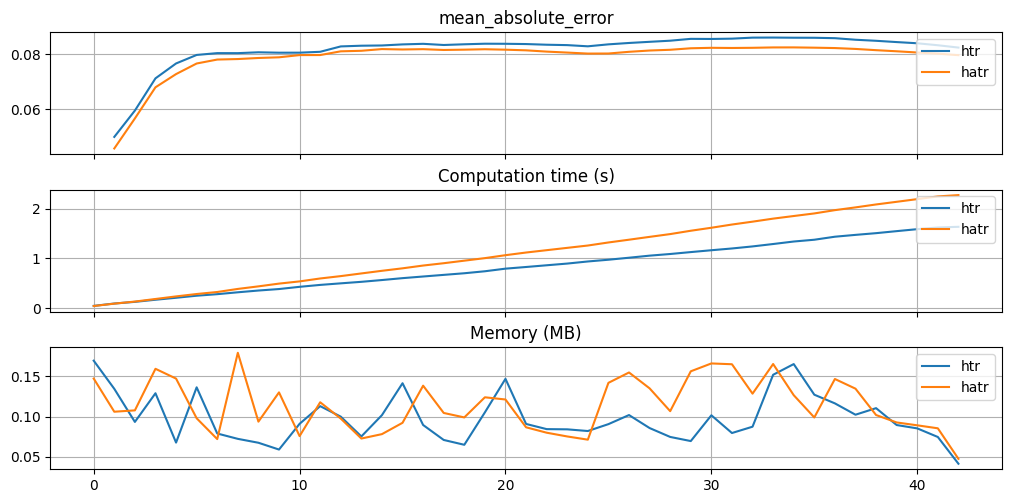

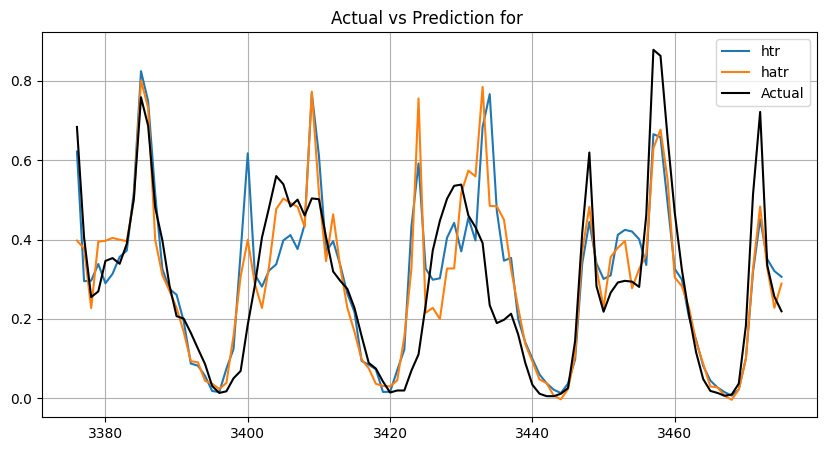

In [42]:
df_labels=["htr", "hatr"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_htr, df_eval_hatr], log_y=False, df_labels=df_labels, metric=metric)
plot_bml_oml_horizon_predictions(df_true = [ df_true_htr[a:b], df_true_hatr[a:b]], target_column=target_column,  df_labels=df_labels, log_y=False)

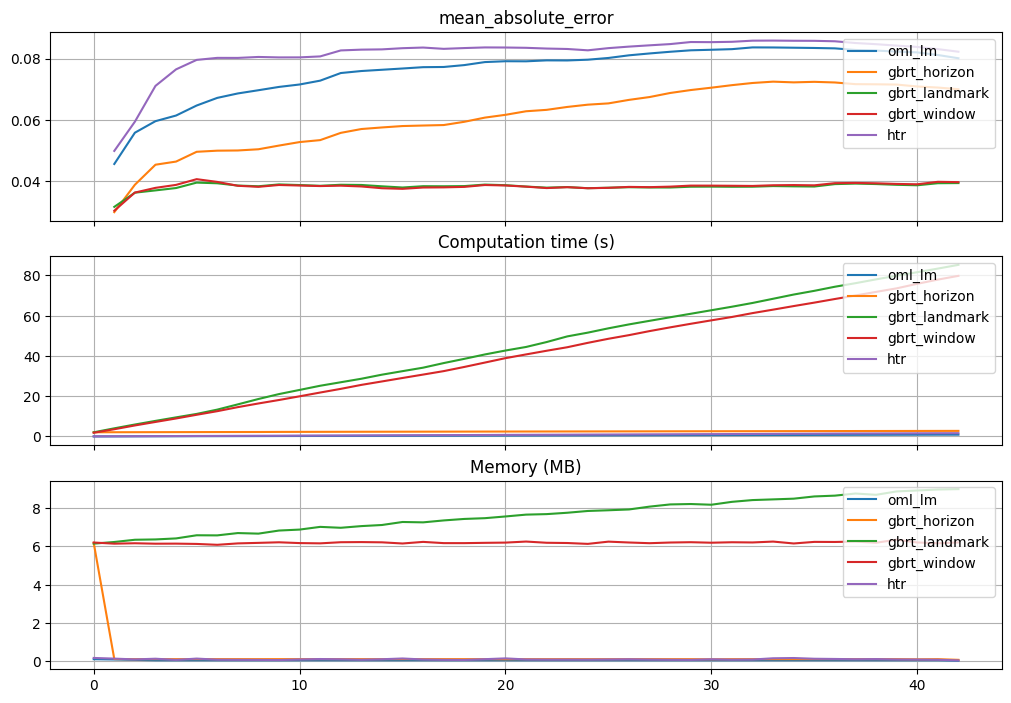

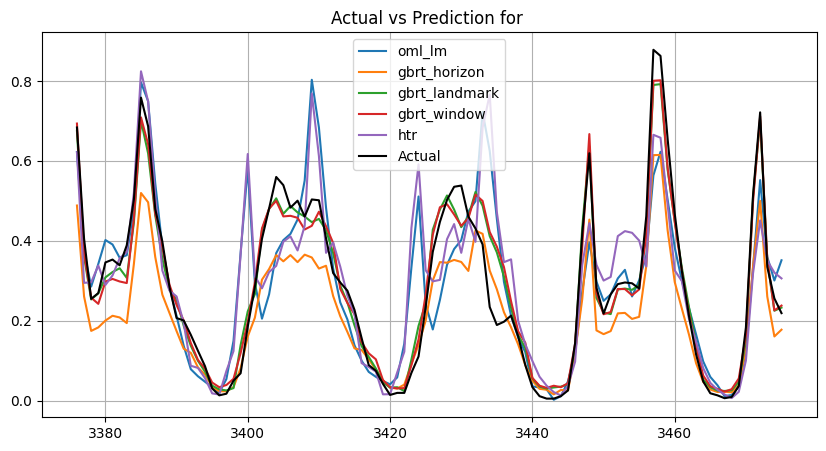

In [43]:
df_labels=["oml_lm", "gbrt_horizon", "gbrt_landmark", "gbrt_window", "htr"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_oml_linear, df_eval_bml_horizon_gbrt, df_eval_bml_landmark_gbrt, df_eval_bml_window_gbrt, df_eval_htr], df_labels=df_labels, cumulative=True, log_y=False, log_x=False, figsize=(10,7), metric=metric, filename="./figures/" + experiment_name+"_overall_metrics.pdf")
plot_bml_oml_horizon_predictions(df_true = [df_true_oml_linear[a:b], df_true_bml_horizon_gbrt[a:b], df_true_bml_landmark_gbrt[a:b], df_true_bml_window_gbrt[a:b], df_true_htr[a:b]], target_column=target_column,  df_labels=df_labels, filename="./figures/" + experiment_name+"_overall_predictions.pdf")